In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
from unet import UNet

import matplotlib.pyplot as plt
from PIL import Image
torch.set_printoptions(profile="full", linewidth=200, precision=2)

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
len(training_data)

60000

In [4]:
X_train_sample, _ = training_data[0]
X_train_sample = X_train_sample.unsqueeze(1) # adding the channel dimension
X_train_sample = torch.nn.functional.interpolate(X_train_sample, 32) # the dimension accepted by UNet should be multipe of 32
X_train_sample.shape, X_train_sample.dtype

(torch.Size([1, 1, 32, 32]), torch.float32)

In [5]:
len(training_data)

60000

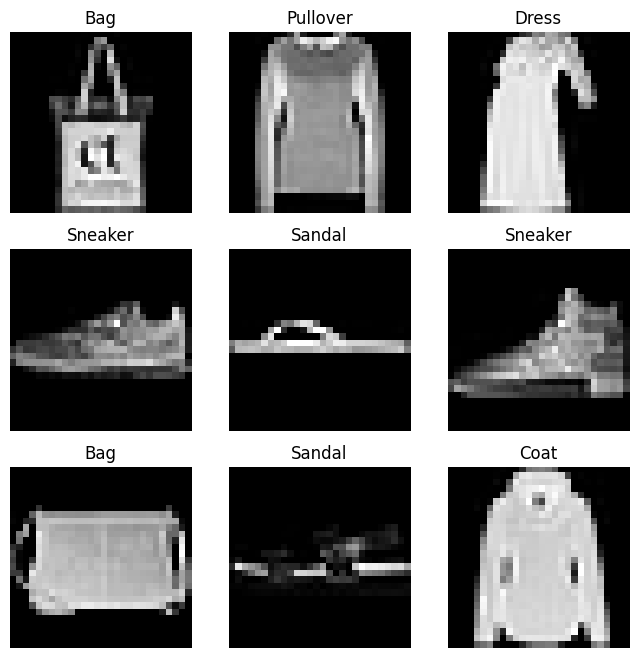

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
t = (torch.rand(10)*10).long()
img = torch.randn((10, 1, 32, 32))
print(f"image input shape to UNet {img.shape}")
unet =UNet()
out = unet(img, t)
print(f"image output shape from UNet {out.shape}")

image input shape to UNet torch.Size([10, 1, 32, 32])
image output shape from UNet torch.Size([10, 1, 32, 32])


In [8]:
sum([p.numel() for p in unet.parameters()]) / 1e6

35.713281

In [9]:
class DDPM():
    def __init__(self, T: int, model: nn.Module, device: str):
        super(DDPM, self).__init__()

        self.T = T
        self.device = device
        self.function_approximator = model.to(device)
        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        

    def training(self, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """
        # sampling from the training dataset
        x0 = DDPM.sample_batch(batch_size, self.device)
        t = torch.randint(1, self.T+1, (batch_size,), device=self.device, dtype=torch.long)
        # shape of the noise N(0,I) is the same as the shape of the data
        eps = torch.randn_like(x0)
        # Taking one gradient descent step
        alpha_bar_t = self.alpha_bar[t-1][:, None, None, None]
        eps_predicted = self.function_approximator(torch.sqrt(alpha_bar_t) * x0 + 
                                                   torch.sqrt(1 - alpha_bar_t) * eps, t-1)
        loss = torch.nn.functional.mse_loss(eps, eps_predicted)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()
        
        
    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), use_tqdm=True):
        
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                         device = self.device) # this is xT. Shape of the noise N(0,I), same shape as data

        progress_bar = tqdm if use_tqdm else lambda x : x
        for t in progress_bar(range(self.T, 0, -1)):
            
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)

            t = torch.ones(n_samples, dtype=torch.long, device = self.device) * t

            alpha_t = self.alpha[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            beta_t = self.beta[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)


            mean = 1 / torch.sqrt(alpha_t) * \
                (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * \
                self.function_approximator(x, t-1))
            sigma = torch.sqrt(beta_t)
           
            x = mean + sigma * z
            
        return x # this return x0 at the end of the loop      

        
    @torch.no_grad()
    @staticmethod
    def sample_batch(batch_size, device):
        # Create a DataLoader for the subset
        random_batch_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)         
        # Extract the random batch
        random_batch = next(iter(random_batch_loader))
        # `random_batch` now contains a batch of images (and their labels) from the dataset
        data, _ = random_batch
        # UNet requires images of multiple of 32 pixels
        data = torch.nn.functional.interpolate(data, 32)

        return data.to(device)  # [B, C, 32, 32]

In [10]:
batch_size = 10
# Create a DataLoader for the subset
random_batch_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
# Extract the random batch
random_batch = next(iter(random_batch_loader))
# `random_batch` now contains a batch of images (and their labels) from the dataset
data, labels = random_batch
data = torch.nn.functional.interpolate(data, 32)
data.shape, labels

(torch.Size([10, 1, 32, 32]), tensor([3, 6, 0, 7, 1, 1, 0, 6, 9, 6]))

In [11]:
device = "cuda"
batch_size = 64
unet = UNet(in_ch=1)
optimizer = Adam(unet.parameters(), lr=2e-5)
ddpm = DDPM(1000, unet, device)

In [12]:
training_loss = []
for epoch in tqdm(range(40_000)):
    loss = ddpm.training(batch_size, optimizer)
    training_loss.append(loss)

    if epoch % 500 == 0:
        plt.plot(training_loss)
        plt.savefig(f"./ddpm_train_figs/training_loss.png")
        plt.close()
        plt.plot(training_loss[-1000:])
        plt.savefig(f"./ddpm_train_figs/cropped_training_loss.png")
        plt.close()

    if epoch % 5000 == 0:
        num_images = 81
        samples = ddpm.sampling(n_samples=num_images, use_tqdm = False)
        plt.figure(figsize=(17, 17))
        for i in range(num_images):
            plt.subplot(9, 9, 1 + i)
            plt.axis('off')
            plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(), cmap='gray')
            
        plt.savefig(f'samples_epoch_{epoch}.png')
        plt.close()

        torch.save(model, f'./models/model_paper2')

  0%|                                                                                                                 | 0/40000 [02:17<?, ?it/s]


KeyboardInterrupt: 